In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import custom functions
import sys
sys.path.append("../../../../")
import utils
from tqdm import tqdm
import torch
from skimage.io import imread
from scipy.io import loadmat
from skimage.transform import resize
from skimage.measure import regionprops

import scipy
import skimage
# import custom functions
import os
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph

##
import harmonypy as hm
import anndata as ad
import scanpy as sc
import scanpy.external as sce

In [3]:
cnngnn_embed = np.load('../data/469_double_snap_combo_stable_0326.npy')
cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))
snap = pd.DataFrame(cnngnn_embed)
snap.to_csv('../data/double_snap_combo_stable_0327.csv')

sc.pp.scale(cnngnn_adata)
sc.pp.neighbors(cnngnn_adata, n_neighbors=10, use_rep='X') # this dataset need more local nn
sc.tl.umap(cnngnn_adata)
sc.tl.leiden(cnngnn_adata, resolution=1)

/tmp/ipykernel_1913607/1782010283.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from scipy.stats import entropy

def cluster_refine(label, label_ref, entropy_threshold = 0.75, concen_threshold = 1, max_breaks = 3):
    label_out = label.copy()
    label_out.name = label_out.name + '-refined'
    label_out = label_out.astype(str)
    ll = np.unique(label)
    for l in ll:
        ref_l = label_ref[label == l]
        ref_l_freq = ref_l.value_counts()
        if entropy(ref_l_freq) > entropy_threshold:
            for i in np.arange(max_breaks-1):
                bb = label[label_ref == ref_l_freq.index[i]]
                if entropy(bb.value_counts()) < concen_threshold:
                    label_out[(label == l) & (label_ref == ref_l_freq.index[i])] = l + '-' + str(i)
    
    return label_out.astype('category')

### another help to clean results
def clean_cluster(label):
    ll = label.value_counts().index.to_list()
    i = 0
    dd = {}
    for l in ll:
        dd[l] = str(i)
        i = i+1
    res = []
    for item in label:
        t = dd[item]
        res.append(t)
    return res

In [5]:
res05_input = np.load('../data/469_feature_labels_res0.5.npy')
cnngnn_adata.obs['input'] = res05_input
# cellsnap cluster guarding
snapres1 = cluster_refine(label = cnngnn_adata.obs['leiden'], label_ref=cnngnn_adata.obs['input'])
snapres1f = clean_cluster(snapres1)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'snapres1'}, xlabel='UMAP1', ylabel='UMAP2'>

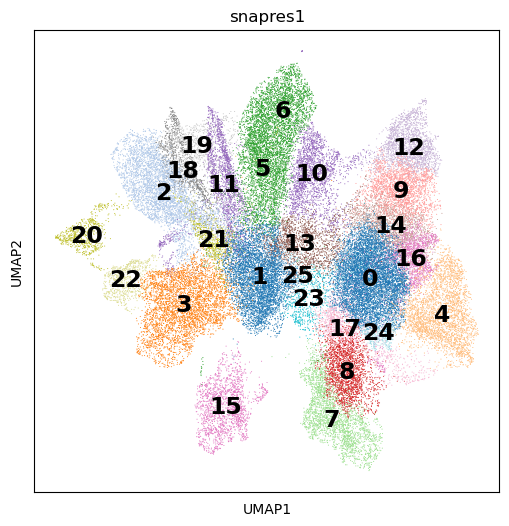

In [6]:
#snapres1.value_counts()
plt.rcParams["figure.figsize"] = (6, 6)
cnngnn_adata.obs['snapres1'] = snapres1f
sc.pl.umap(cnngnn_adata, color='snapres1', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

In [7]:
feat_embed = np.load('../data/469_pc.npy')[:,:30]
counts_adata = ad.AnnData((feat_embed))

In [8]:
sc.pp.neighbors(counts_adata, n_neighbors=10, use_rep = 'X') # this dataset need more local nn
sc.tl.umap(counts_adata)
sc.tl.leiden(counts_adata, resolution=1)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

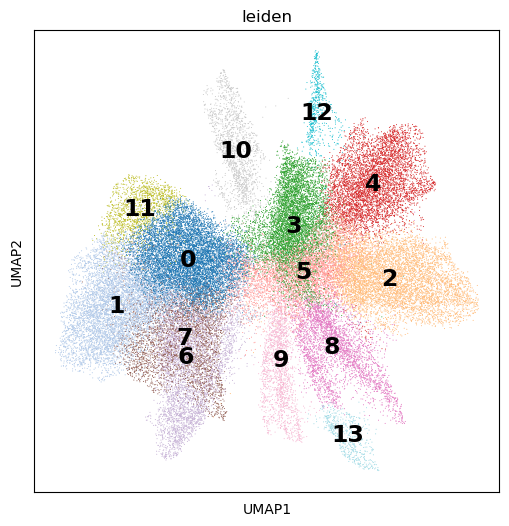

In [9]:
#snapres1.value_counts()
cnngnn_adata.obs['input'] = res05_input
plt.rcParams["figure.figsize"] = (6, 6)
sc.pl.umap(counts_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

In [10]:
meta = pd.read_csv('../data/livcan_meta_y4_x69.csv')
meta['snapres1'] = snapres1f
meta['featres1'] = counts_adata.obs['leiden'].values
meta.head()

,RNA_pca_cluster_default,RNA_pca_cluster_default.1,orig.ident,nCount_RNA,nFeature_RNA,nCount_negprobes,nFeature_negprobes,nCount_falsecode,nFeature_falsecode,fov,...,nFeaturePerCell,propNegativeCellAvg,complexityCellAvg,errorCtPerCellEstimate,percOfDataFromErrorPerCell,qcFlagsFOV,cellType,niche,snapres1,featres1
0,5,8,c,2974,453,0,0,2,2,305,...,217.455291,0.000644,3.677354,56.111567,0.053581,Pass,tumor_2,tumor subtype,12,1
1,14,2,c,4406,463,1,1,4,4,307,...,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor,14,11
2,14,2,c,6162,537,2,2,4,4,307,...,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor,14,1
3,19,19,c,515,262,1,1,16,16,307,...,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,CD3+.alpha.beta.T.cells,tumor,21,3
4,2,6,c,2382,353,2,2,8,8,307,...,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor,16,1


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


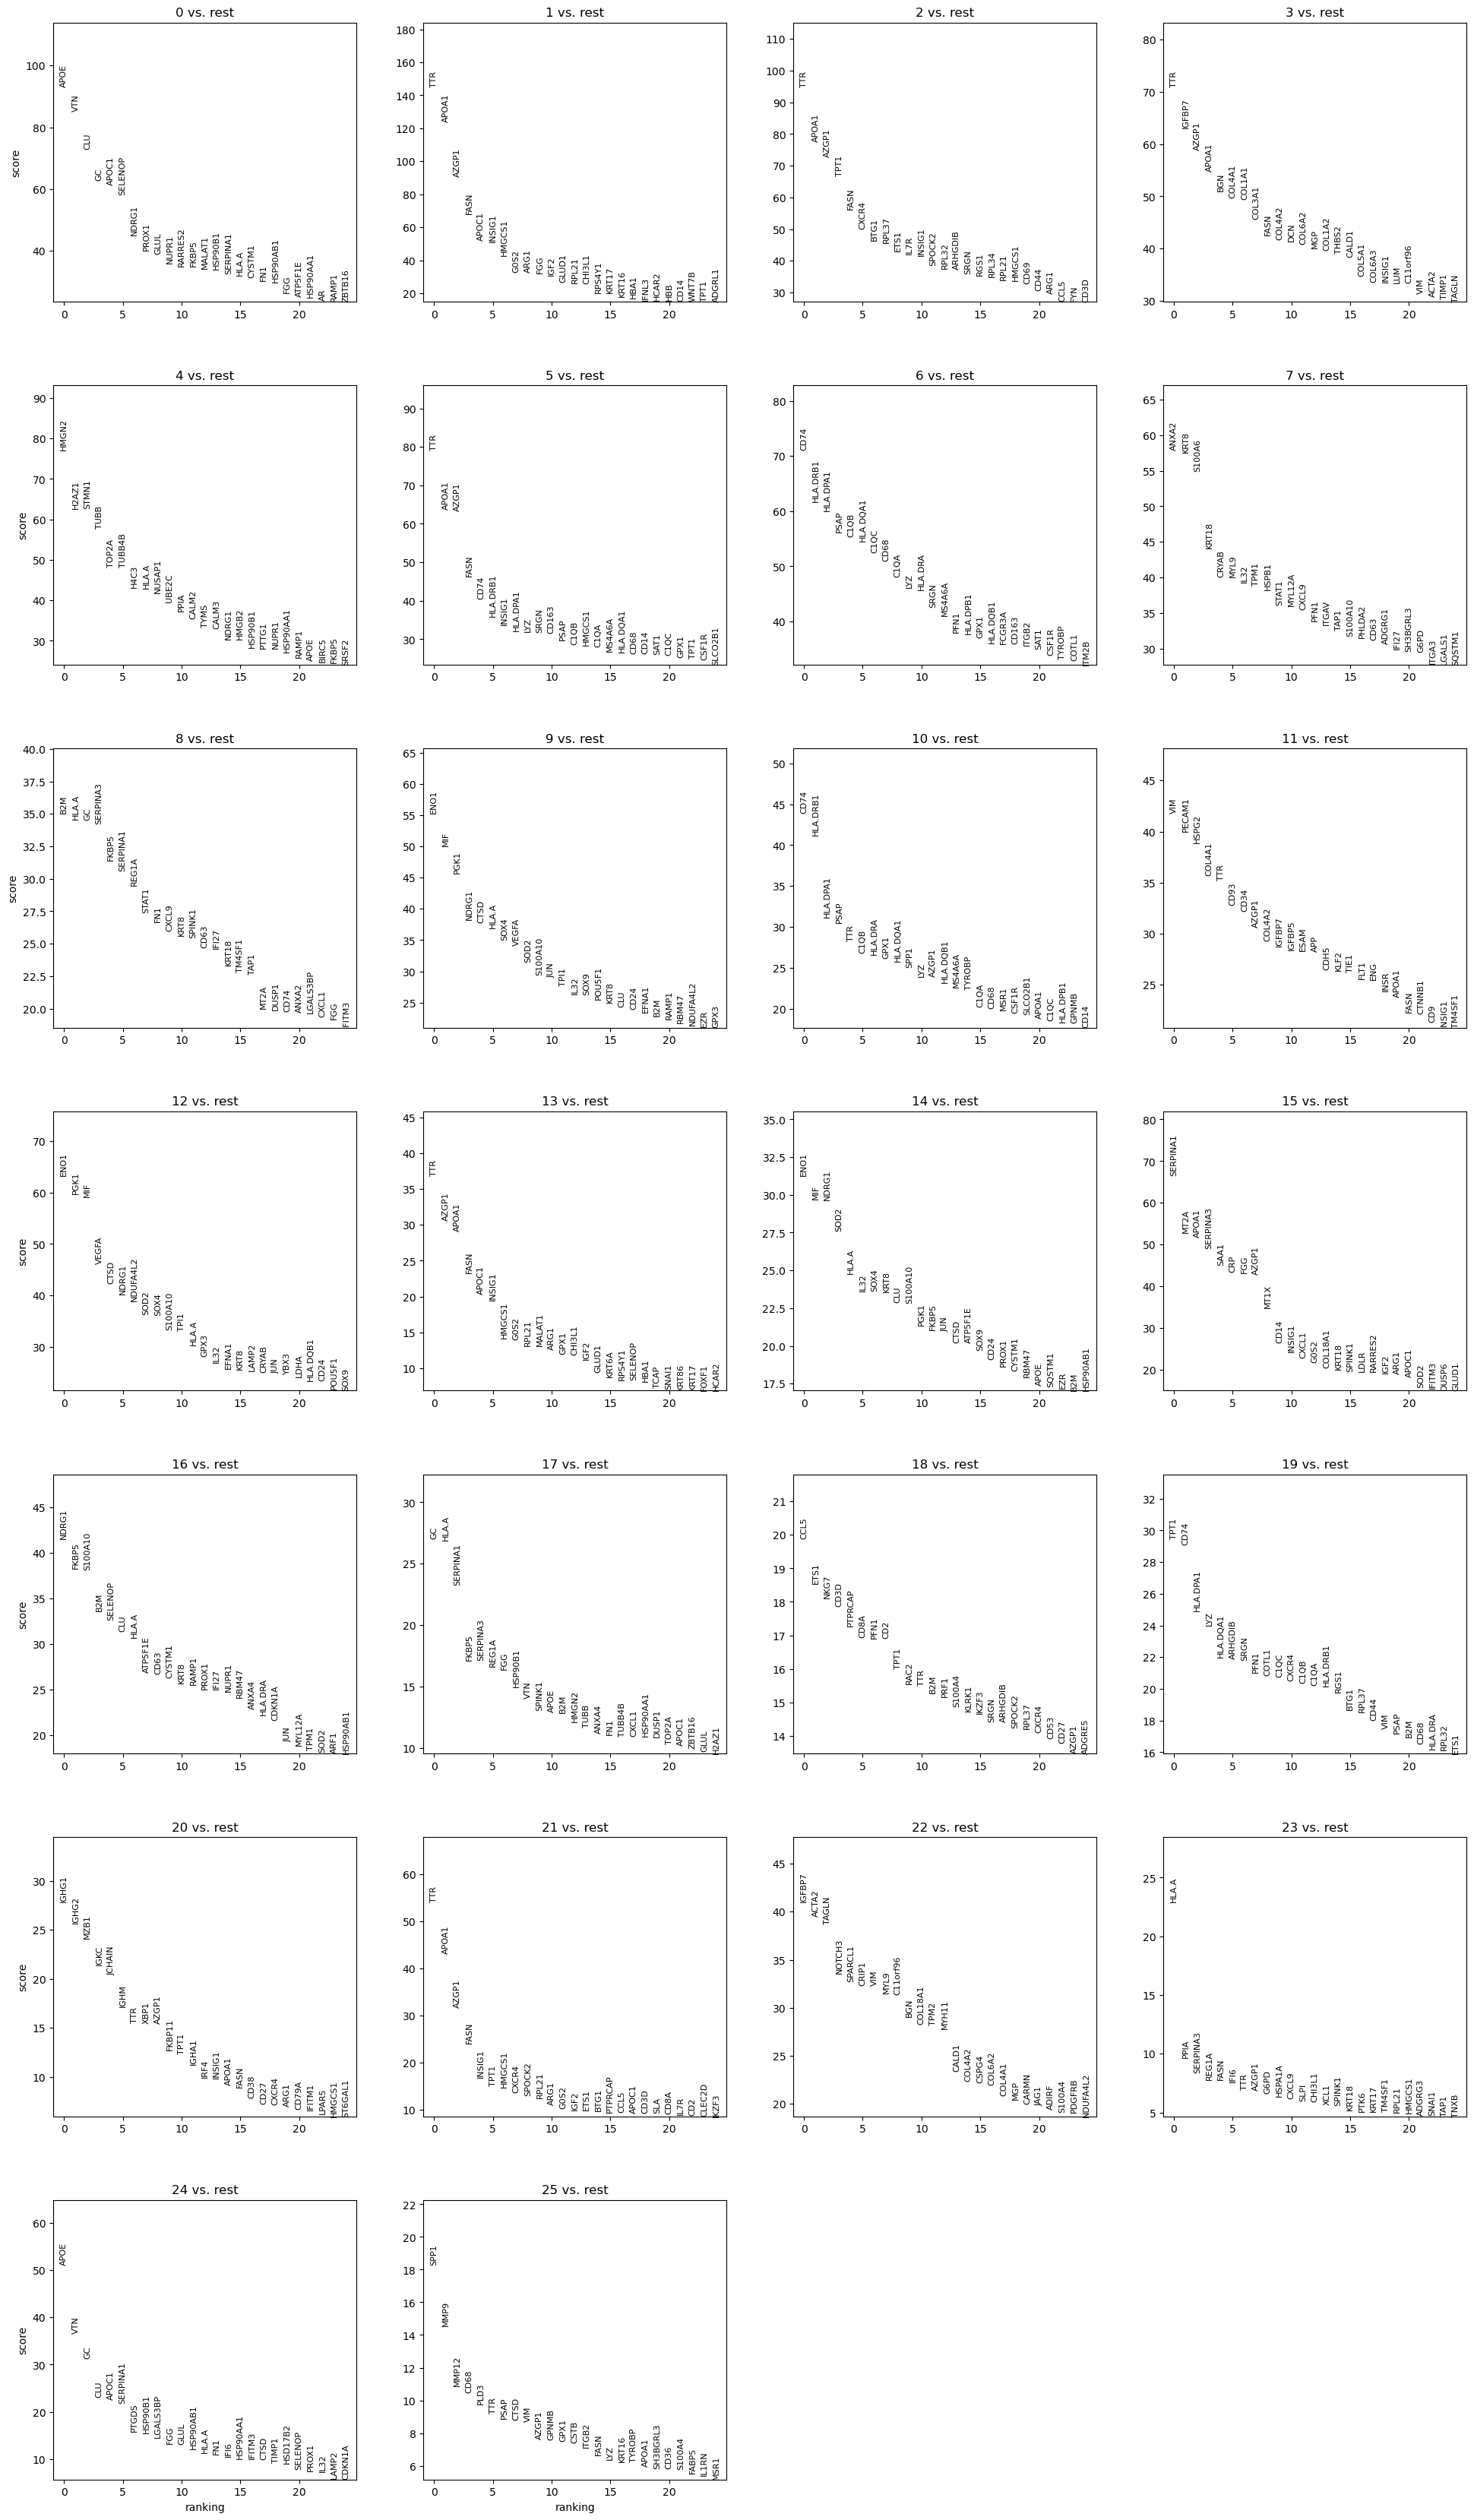

In [14]:
df_count = pd.read_csv('../data/livcan_counts_y4_x69.csv')
df_count.head()
adata = ad.AnnData(
    df_count, dtype=np.float32
)
sc.pp.scale(adata, max_value=10)
adata.obsm['X_umap'] = cnngnn_adata.obsm['X_umap']
adata.obs['leiden'] = cnngnn_adata.obs['snapres1'].values

import warnings
warnings.filterwarnings('ignore')

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [17]:
## put in cellsnap clustering human broad annotations:

meta['snapres1_ann'] = meta['snapres1']

new_cluster_names = {
    '0':'Tumor', '1':'Other', '2':'T', '3':'Stellate', '4':'Tumor', '5':'Macrophage',
    '6':'Macrophage', '7':'Tumor', '8':'Tumor', '9':'Tumor', '10':'Macrophage', '11':'LSEC',
    '12':'Tumor', '13':'Other', '14':'Tumor', '15':'Hepatocytes', '16':'Tumor', '17':'Tumor',
    '18':'T', '19':'T', '20':'B', '21':'Other', '22':'Stellate', '23':'Tumor', '24':'Tumor',
    '25':'Macrophage'
}

meta=meta.replace({"snapres1_ann": new_cluster_names})
meta.snapres1_ann.value_counts()

snapres1_ann
Tumor          24690
Macrophage      7824
Other           7393
T               5904
Stellate        4597
LSEC            2075
Hepatocytes     1688
B                696
Name: count, dtype: int64

In [18]:
## put in cellsnap clustering human broad annotations:

meta['featres1_ann'] = meta['featres1']

new_cluster_names = {
    '0':'Tumor', '1':'Tumor', '2':'Macrophage', '3':'Other', '4':'T', '5':'Macrophage',
    '6':'Tumor', '7':'Tumor', '8':'Stellate', '9':'LSEC', '10':'Hepatocytes', '11':'Tumor',
    '12':'B', '13':'Stellate'
}

meta=meta.replace({"featres1_ann": new_cluster_names})
meta.featres1_ann.value_counts()

featres1_ann
Tumor          24402
Macrophage     11207
Other           6082
T               5193
Stellate        3871
LSEC            1898
Hepatocytes     1596
B                618
Name: count, dtype: int64

In [19]:
meta.to_csv('../data/livcan_meta_y4_x69_withClusters_0327.csv')